# Positional Encoding

- 단어들이 순차적으로 들어가던 RNN 구조와 달리, **Transformer 모델들의 경우 문장 속 단어들이 한번에 다 같이 들어가게 됨. (병렬적)**
-> but, Transformer의 단어 임베딩 벡터 그 자체만으로는 단어들의 위치정보를 판단할 수 없으며, NLP task에서는 문장 내 단어들의 순서가 매우 중요함.

 ex. Taeyeon loves coffee != Coffee loves Taeyeon : 어순에 따라서 문장의 의미가 달라짐

이를 해결하기 위해 Transformer 논문에서는 Positional Encoding을 이용해 토큰들의 상대적 or 절대적 위치 정보를 주입시켜 위치마다 고유한 값들을 만들어주어 단어의 위치를 구별해줄 수 있게 함!

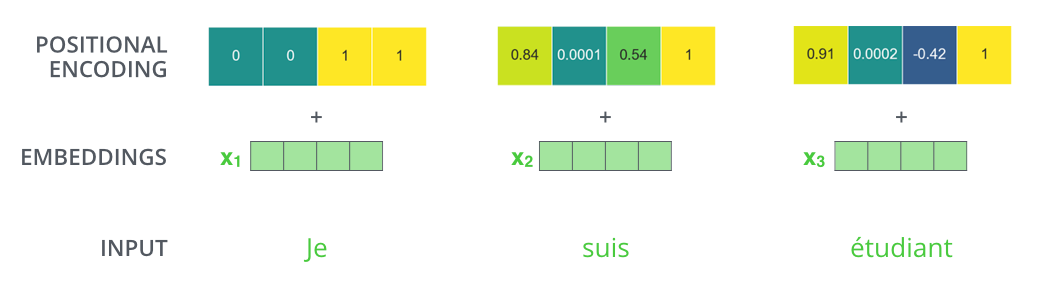

이때, 위 그림과 같이 embedding 단계에서, positional encoding 부분을 추가함.
-  embedding vector랑 같은 dimension을 가지므로 embedding vector에 positional encoding vector를 단순히 더해주면 됨!

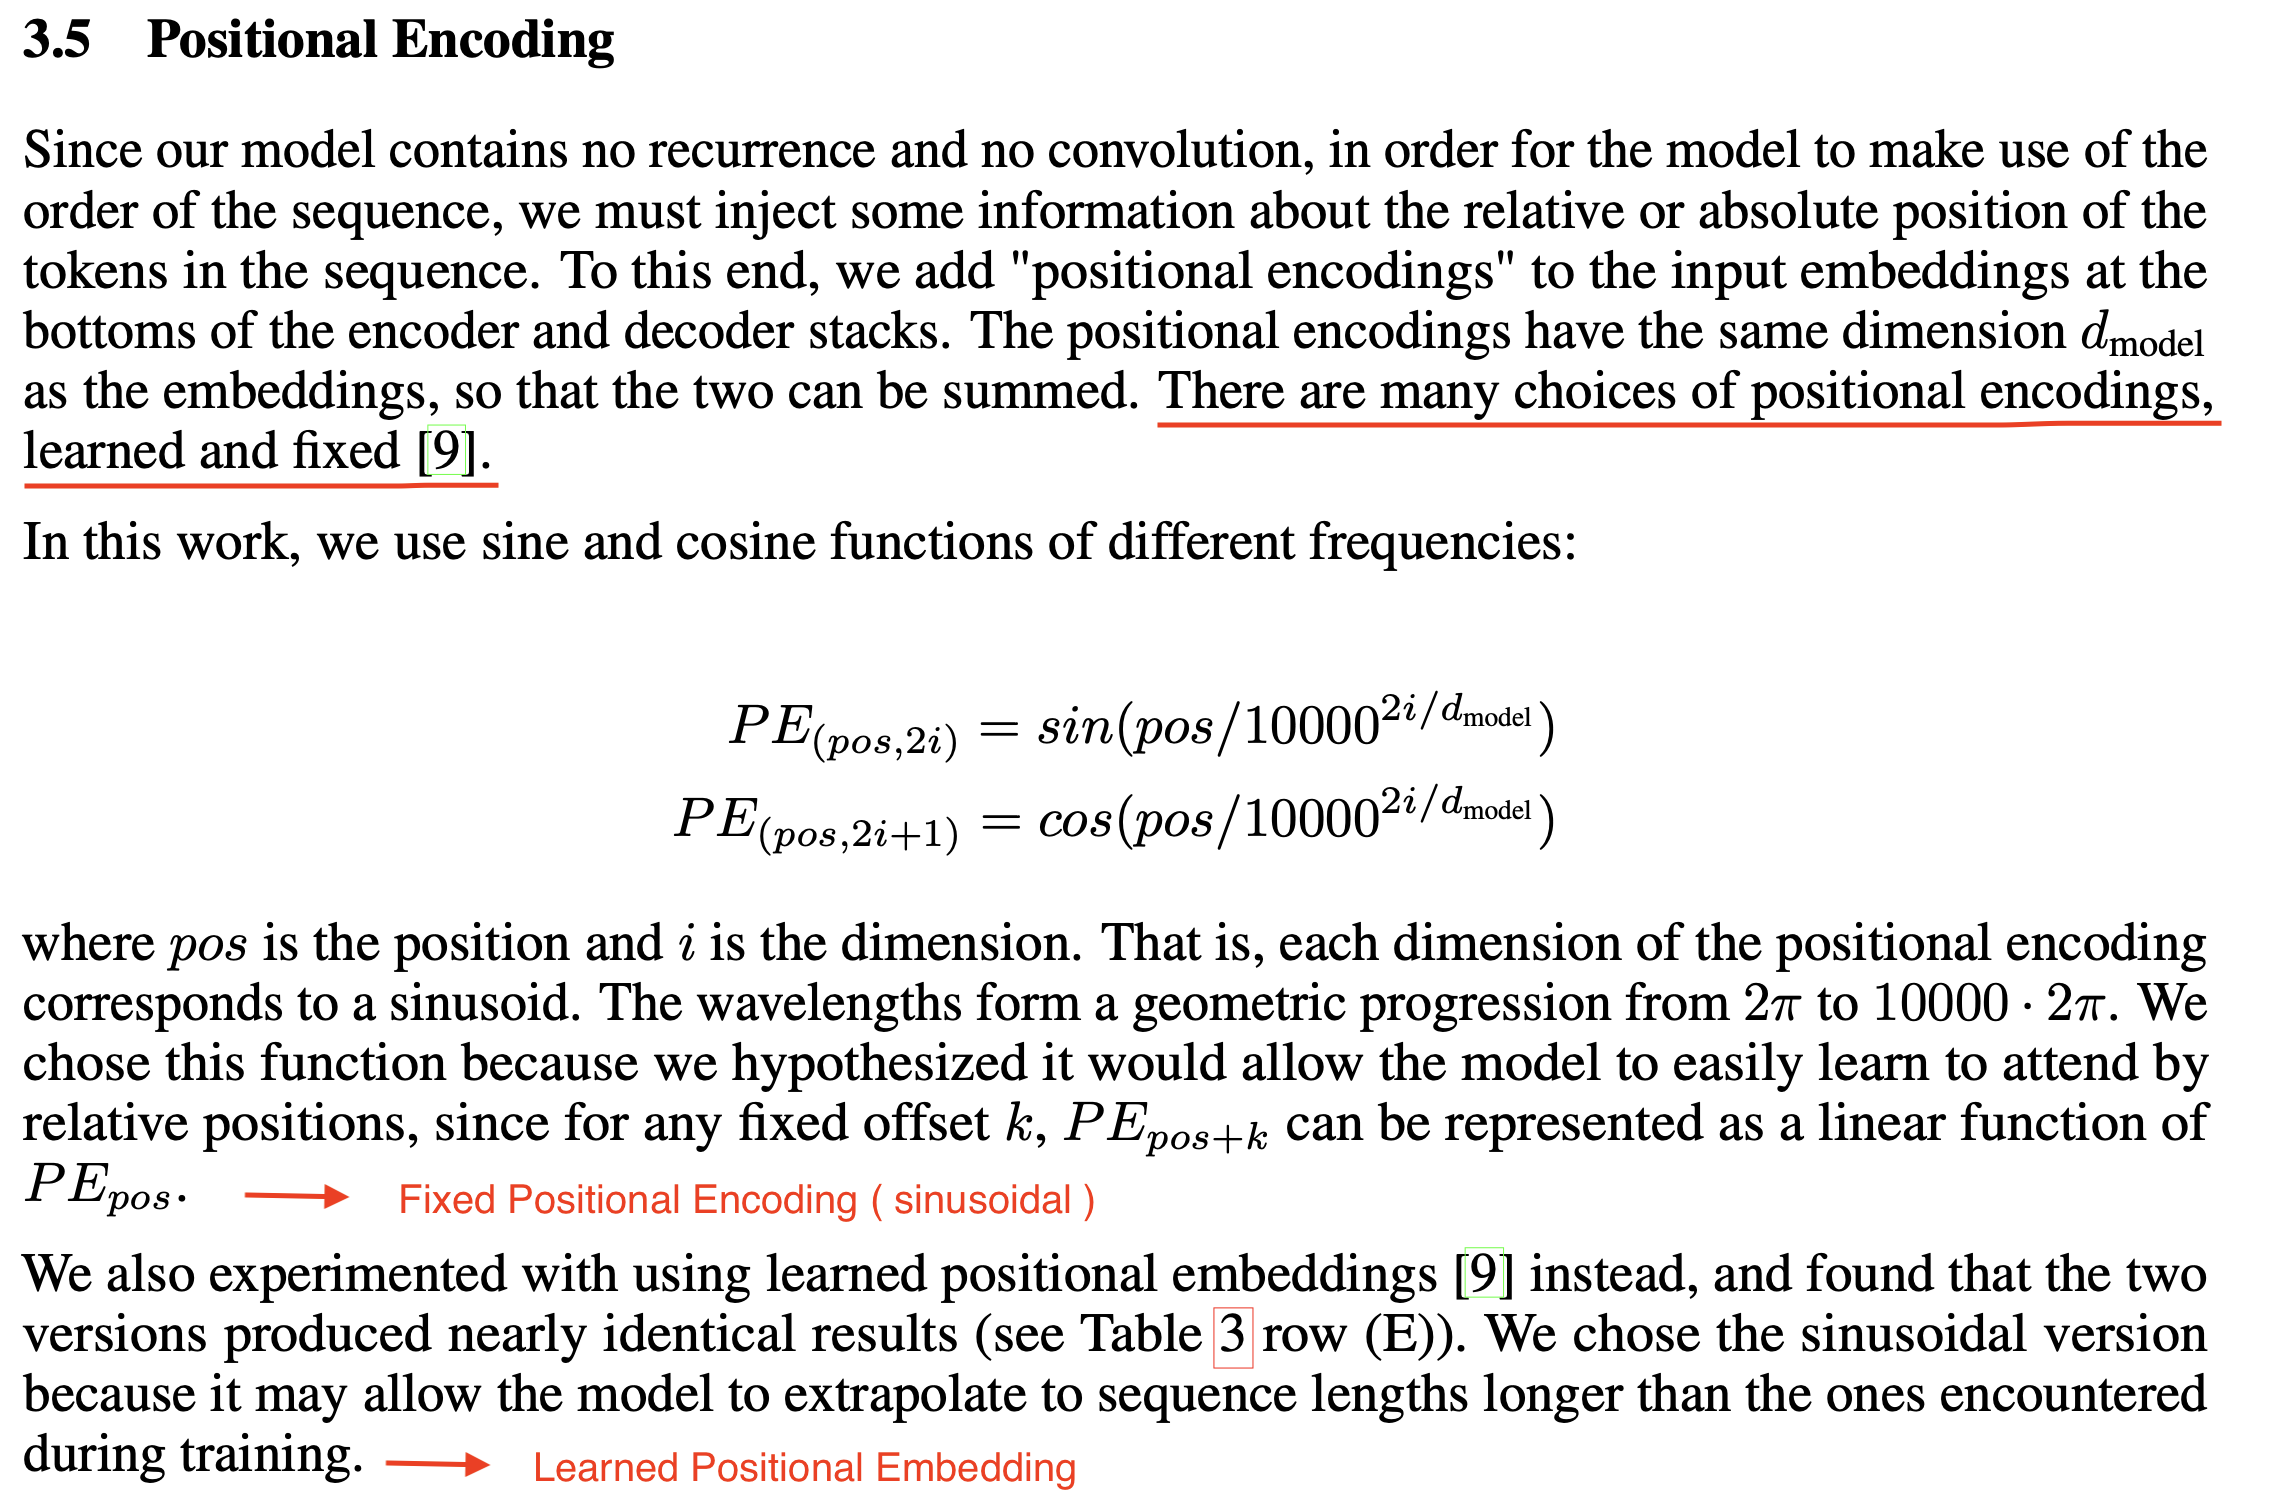

Positional Encoding 방법으로는 Fixed(고정된) 방법과 Learnable 방법 2가지가 있음 !

## 1. Fixed Positional Encoding ( Sinusoidal Encoding )
- sin함수와 cos함수를 이용해서 위치정보를 하나의 고정된 벡터로 만들어줌. 학습 시 갱신되는 부분이 아님.
- sin cos 함수를 사용함으로써, 상대적인 위치 정보를 표현해줄 수 있다! 문장의 길이가 얼마가 되더라도 항상 사용 가능

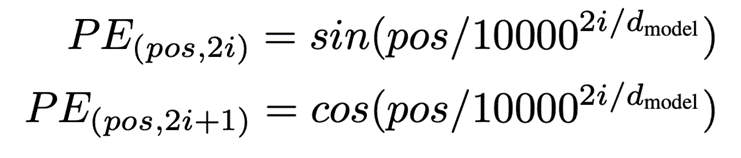

### sin cos 함수를 사용한 이유?

1. 의미 정보(Input Embedding) 값이 변질되지 않도록 위치벡터가 너무 크면 안 됨.

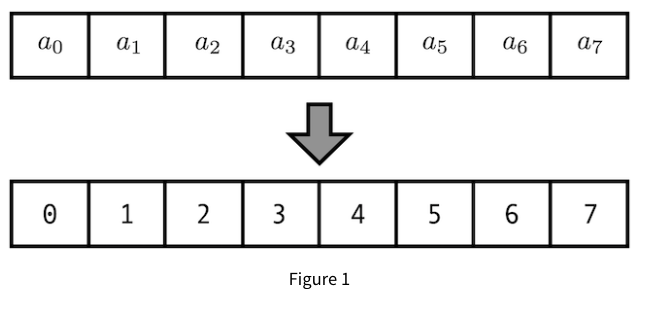
- 0,1,2,3,4,5 .. 와 같이 단순히 시퀀스 길이에 맞춰서 순차적으로 증가하는 정수값을 부여할 수도 있음.
- 하지만, 이 경우 시퀀스 길이가 엄청나게 커지면, 의미정보에 비해 위치벡터값이 큰 값을 가지게 되어, 단어의 의미정보가 변질 될 수 있음.


➡️ sin cos 함수의 경우에는 -1 ~ 1 값으로 표현이 되기 때문에 의미정보가 변질될 만큼의 큰 값이 아니므로 괜찮다.


2. 같은 위치의 토큰은 항상 같은 위치 벡터값을 가져야 하고, 다른 위치의 토큰은 다른 위치벡터값을 가져야 함.
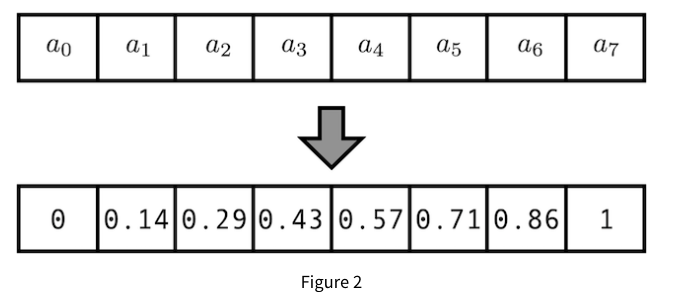



 - 위치 벡터 크기가 커지지 않게, 순차적인 정수값을 시퀀스의 길이로 나눠서 normalization 한 인코딩을 적용할 수도 있음.         
 - 하지만, 이 경우 시퀀스 길이에 따라 같은 위치 정보에 해당하는 위치 벡터값이 달라질 수 있음. (ex. 시퀀스 길이가 5이면 0.6은 3번째 원소지만, 시퀀스 길이가 30이면 0.6은 18번째 원소)


➡️ 주기함수를 사용하면 연속적이면서도 위치정보의 차이를 표현할 수 있음. 이때, 하나의 주기함수를 사용할 경우 주기마다 같은 값을 가질 수 있음 -> 임베딩 벡터 차원마다 sin cos을 번갈아 사용해줌으로써 같은 값을 가지는 것을 방지.

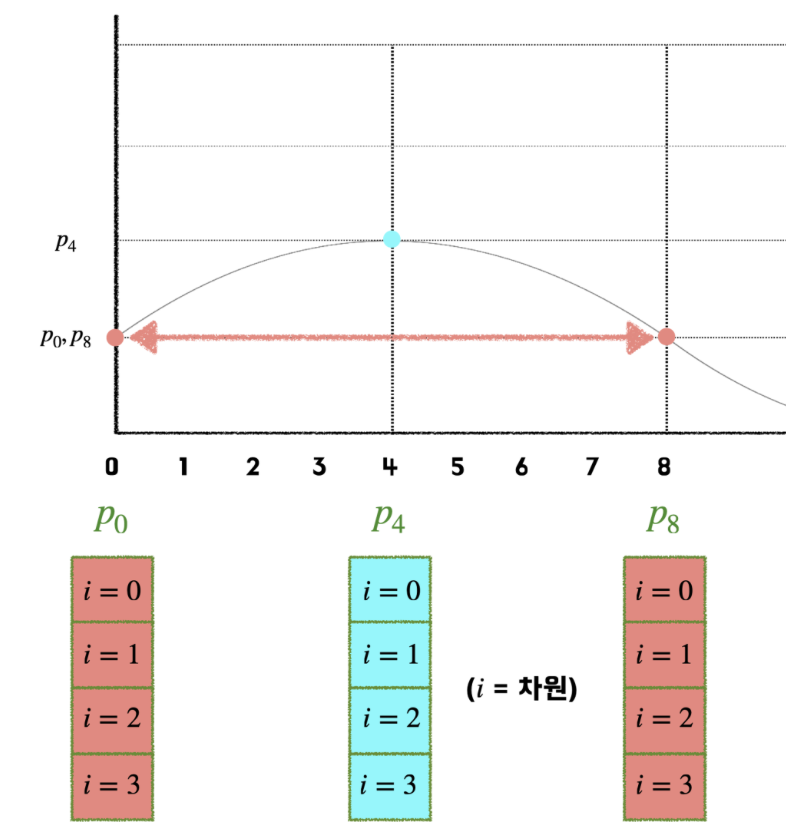

In [ ]:
class SinPositionEmbeddings(nn.Module):
    def __init__(self,dim,T=1000):
        super().__init__()
        self.dim = dim
        self.T = T
    @torch.no_grad()
    def forward(self,steps):
        device = steps.device
        half_dim = self.dim // 2
        embeddings = math.log(self.T) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = steps[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
print ("Ready.")

## 2. Learnable Positional Embeding

-> learnable parameter로 모델이 학습되면서 위치 정보를 어떻게 표현하면 좋을지를 스스로 학습하게 됨. 즉 모델이 학습되면서 계속해서 update 되는 부분!

In [ ]:
# 예시
positions = nn.Parameter(torch.randn(n, emb_dim))

''' Parameter containing:
tensor([[-7.5633e-01, -1.6639e+00, -2.6427e+00,  ...,  5.7573e-01,
          1.2425e-02, -3.3126e-01],
        [ 5.5671e-01, -7.4366e-01,  1.0763e+00,  ...,  1.8912e+00,
          6.1852e-01, -1.7474e+00],
        [-6.7134e-01,  1.8273e+00,  6.1051e-01,  ..., -4.9538e-01,
         -9.5468e-01,  7.5081e-01],
        ...,
        [ 1.6158e+00,  1.0636e+00,  1.8022e+00,  ..., -7.2855e-03,
          1.5266e+00,  6.0337e-01],
        [ 3.8256e-01,  4.7324e-01,  2.5039e+00,  ...,  3.9797e-01,
         -1.3978e+00,  5.4772e-01],
        [ 3.2329e-01, -2.6032e-01,  9.4217e-01,  ...,  1.7369e+00,
         -1.3033e+00,  3.6582e-04]], requires_grad=True)'''

- learnable positional Embedding의 단점 : training될 때 들어왔던 sequence보다 더 긴 길이의 sequence가 들어왔을 때, 위치 임베딩 값을 생성할 수 없음

## 어떤 것을 사용해야 하나?

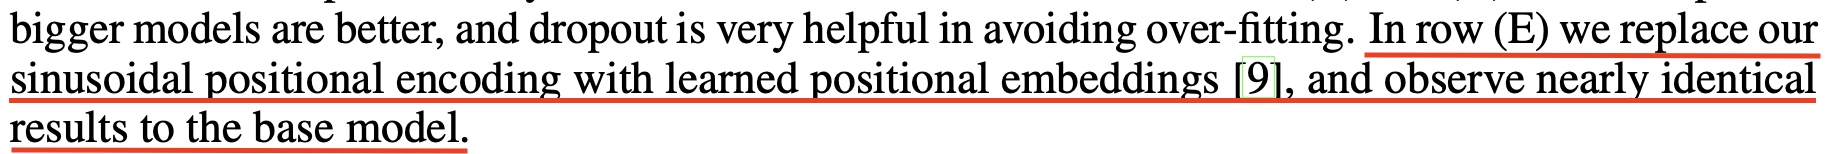

- 논문에서는 Positional Encoding 방법 (Sinusoidal) 을 사용했으나, 논문에서 Positional Embedding으로도 실험해본 결과, 둘 중 어느 방법을 사용하던지 비슷한 성능이 나왔다고 함!

- Task에 따라서 Task에 맞는 방법을 사용하는 것이 괜찮아 보임!

- 그러나, Positional Encoding의 경우 입력 문장의 길이가 매우 길어도 항상 임베딩을 만들 수 있지만,
Positional Embedding은 임베딩층의 크기보다 긴 길이의 문장이 입력됐을 때, 위치 임베딩을 만들지 못하기 때문에
NLP Task에서는 Positional Encoding(Sinusoidal Encoding)을 사용하는 게 더 적합하지 않을까 생각해볼 수 있음!

- 반면에, 이미지 데이터는 대체로 고정된 크기를 갖고 있으므로, 학습가능한 위치 임베딩을 사용하는게 이미지의 특정 context나 구조에 더 잘 맞다고 생각해볼 수 있다.

[참고자료]
- https://www.blossominkyung.com/deeplearning/transfomer-positional-encoding
- https://www.youtube.com/watch?v=1biZfFLPRSY
- https://heekangpark.github.io/ml-shorts/positional-encoding-vs-positional-embedding
- http://jalammar.github.io/illustrated-transformer/
- https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3